In [43]:
import pandas as pd
import numpy as np 
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [58]:
df = pd.read_csv("Watches Bags Accessories.csv", encoding='latin-1')

################  Basic Prepocessings   #################

##  remove  all missing values 
df.dropna(inplace=True)

## remove the '/5' part from ratings and convert it into numeric 
df['Rating in Stars'] = df['Rating in Stars'].apply(lambda x: re.sub(r'[^0-9.]', '', x)).astype(float)


### Normalise the rating count 
min_value = df['Rating Count'].min()
max_value = df['Rating Count'].max()
df['Rating Count'] = (df['Rating Count'] - min_value) / (max_value - min_value)

# In soldcount replace k with 1000
df['Sold Count'] = df['Sold Count'].str.replace('k', '000', regex=True)  # Replace 'k' with '000'
df['Sold Count'] = df['Sold Count'].str.replace(r'\D', '', regex=True).astype(int)  # Remove non-numeric characters and convert to int


#### Delivery  : 1 if it is free ,  0 else
df['Delivery'] = df['Delivery'].apply(lambda x: 1 if x != 0 else 0)


df.drop(columns=['Currency','Link','Title','Voucher'],inplace=True)

## Remove the Rs part from the original price and make it numeric 
df['Original Price'] = df['Original Price'].str.replace('Rs. ', '').str.replace(',', '').astype(int)
df['Current Price'] = pd.to_numeric(df['Current Price'].str.replace('Rs. ', '').str.replace(',', ''))
 
 
print(df.shape)


(979, 7)


In [59]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Category' column with numerical encoding
df['Category'] = label_encoder.fit_transform(df['Category'])
df.head(5)

,Rating in Stars,Rating Count,Sold Count,Delivery,Current Price,Original Price,Category
0,4.65,0.127319,6,1,287,520,0
1,4.35,0.052764,1,1,270,999,0
2,4.55,0.010265,452,1,225,750,0
3,4.65,0.009184,332,1,160,299,0
4,4.45,0.009724,476,1,198,300,0


In [60]:
y = df['Sold Count']
X = df.drop(columns=['Sold Count'])
X_train , X_test , y_train , t_test = train_test_split(X,y,test_size=0.3)

In [61]:
X_train

,Rating in Stars,Rating Count,Delivery,Current Price,Original Price,Category
986,4.65,0.016207,1,499,850,6
713,4.45,0.094003,1,96,199,4
134,3.55,0.003962,1,1301,2019,0
391,4.75,0.209076,1,419,1050,2
56,5.00,0.000900,1,279,333,0
...,...,...,...,...,...,...
233,4.65,0.035476,1,422,700,1
409,4.45,0.018909,1,844,1299,2
177,4.65,0.051864,1,749,999,1
740,4.55,0.144607,1,438,999,5


In [66]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming y_train is your target variable with numeric values

# Define hyperparameter grids for GridSearchCV
xgb_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}


xgb_model = XGBRegressor()
rf_model = RandomForestRegressor()

xgb_grid_search = GridSearchCV(xgb_model, xgb_param_grid, cv=5, scoring='neg_mean_squared_error')
xgb_grid_search.fit(X_train, y_train)
print("Best parameters for XGBoost:", xgb_grid_search.best_params_)
print("Best score for XGBoost:", xgb_grid_search.best_score_)


rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='neg_mean_squared_error')
rf_grid_search.fit(X_train, y_train)
print("Best parameters for Random Forest:", rf_grid_search.best_params_)
print("Best score for Random Forest:", rf_grid_search.best_score_)

Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best score for XGBoost: -33514.056467968425
Best parameters for Random Forest: {'max_depth': 7, 'min_samples_split': 5, 'n_estimators': 100}
Best score for Random Forest: -33472.96507013956


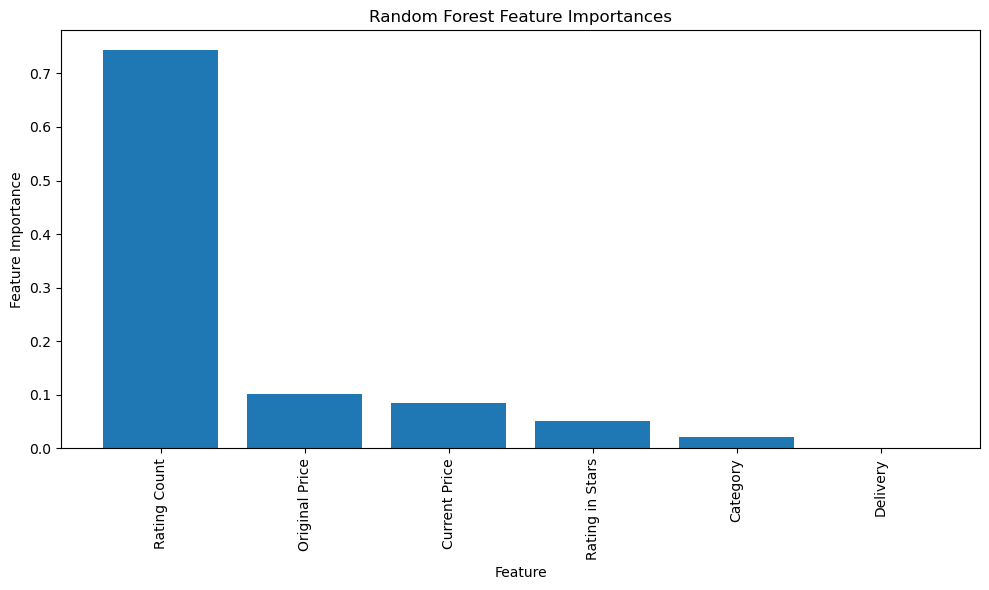

In [67]:
#####  Now lets analyse what are the features that affects  'count sold' the most 

 
best_rf_model = rf_grid_search.best_estimator_

best_rf_model.fit(X_train, y_train)


feature_importances = best_rf_model.feature_importances_


feature_names = X_train.columns


sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]


plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_feature_importances)), sorted_feature_importances, align='center')
plt.xticks(range(len(sorted_feature_importances)), sorted_feature_names, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.tight_layout()
plt.show()

### So it is clearly evident that the the Rating Count make a significant impact on  the items sold . So we can expect that the items categories which are exihibiting a  high rating count will have a considerably high demand comapred to the other categories  